## Import stuff and set random seed

In [34]:
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt

import time

np.random.seed(69)

## Prep train data

In [35]:
datasets = sio.loadmat('./data.mat')

In [36]:
# Remove keys that aren't modulation schemes
del(datasets['__header__'], datasets['__globals__'], datasets['__version__'])

In [37]:
# Concat all datas
# train_data = np.concatenate([mod_scheme[0] for dataset in datasets for mod_scheme in datasets[dataset][0]], axis=0)
train_data = np.vstack([mod_scheme[0] for dataset in datasets for mod_scheme in datasets[dataset][0]])

In [38]:
train_data.shape

(2048, 128, 2)

In [39]:
[dataset for dataset in datasets for mod_scheme in datasets[dataset][0]]

['bpsk', 'qpsk']

In [40]:
# Number of classes
num_classes = len(datasets)
size = int(train_data.shape[0]/num_classes)

train_labels = np.zeros((train_data.shape[0],1))

for i in range(num_classes):
    train_labels[(i)*size:(i+1)*size] = np.ones((size, 1)) * i

# One hot encoding
labels = np.reshape(train_labels, [-1]) # Reshape into (N,) from (N,1), otherwise assignments get messed up
labels_encoded = np.zeros((labels.shape[0], num_classes))
labels_encoded[np.arange(labels.shape[0]), labels.astype(int)] = 1

train_labels = labels_encoded

In [41]:
# train_data = train_data[8:-8]
# labels_encoded = labels_encoded[8:-8]

train_data.shape

(2048, 128, 2)

## Make model

In [42]:
import tensorflow as tf

my_input = tf.placeholder(tf.float32, shape=(None, train_data.shape[1], train_data.shape[2]))

# Create conv net
x_image = tf.reshape(my_input, [-1, train_data.shape[1], 2, 1])

num_filt0 = 8
num_filt1 = 4

# First conv layer
W_conv1 = tf.Variable(tf.truncated_normal([8, 2, 1, num_filt0], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filt0]))

h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1)

# Second conv layer
W_conv2 = tf.Variable(tf.truncated_normal([16, 1, num_filt0, num_filt1], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filt1]))

h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1, W_conv2, strides=[1, 1, 1, 1], padding='VALID') + b_conv2)

h_flat = tf.reshape(h_conv2, [-1, h_conv2.get_shape().as_list()[1] * num_filt1])

nn_out = tf.layers.dense(inputs=h_flat, units=num_classes, activation=tf.nn.relu)

## Set up training policy

In [43]:
onehot_labels = tf.placeholder(tf.float32, shape=(None, num_classes))

loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=nn_out)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.003)

train_op = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(nn_out, 1), tf.argmax(onehot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train and show loss

Epoch 0, loss 0.383692, training accuracy 0.875
Epoch 1, loss 0.00259993, training accuracy 1
Epoch 2, loss 0.00561037, training accuracy 1
Epoch 3, loss 0.000904533, training accuracy 1
Epoch 4, loss 0.000875185, training accuracy 1
Epoch 5, loss 0.00231596, training accuracy 1
Epoch 6, loss 0.000495757, training accuracy 1
Epoch 7, loss 0.000254092, training accuracy 1
Epoch 8, loss 0.000253126, training accuracy 1
Epoch 9, loss 0.000247547, training accuracy 1
Epoch 10, loss 7.17047e-05, training accuracy 1
Epoch 11, loss 5.21066e-05, training accuracy 1
Epoch 12, loss 0.000140497, training accuracy 1
Epoch 13, loss 6.59159e-05, training accuracy 1
Epoch 14, loss 0.000100866, training accuracy 1
Epoch 15, loss 3.04565e-05, training accuracy 1
Epoch 16, loss 4.14445e-05, training accuracy 1
Epoch 17, loss 2.98664e-05, training accuracy 1
Epoch 18, loss 2.27453e-05, training accuracy 1
Epoch 19, loss 1.762e-05, training accuracy 1


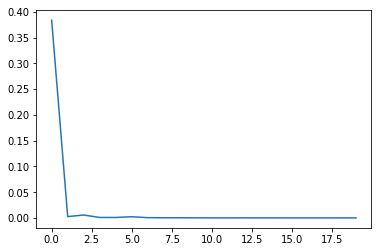

8.309926509857178


In [44]:
batch_size = 32
num_epochs = 20

losses = []

t = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        # Reshuffle after each new epoch
        indexes = np.arange(train_labels.shape[0])
        np.random.shuffle(indexes)

        train_data = train_data[indexes]
        train_labels = train_labels[indexes]

        for i in range(int(train_labels.shape[0]/batch_size)):
            batch = train_data[range(i*batch_size,(i+1)*batch_size)]
            batch_labels = train_labels[range(i*batch_size,(i+1)*batch_size)]

            train_op.run(feed_dict={my_input: batch, onehot_labels: batch_labels})

            train_accuracy = accuracy.eval(feed_dict={my_input: batch, onehot_labels: batch_labels})
            train_loss = loss.eval(feed_dict={my_input: batch, onehot_labels: batch_labels})

        losses.append(train_loss)
        print('Epoch %d, loss %g, training accuracy %g' % (epoch, train_loss, train_accuracy))
        

elapsed = time.time() - t

plt.plot(losses)
plt.show()

print(elapsed)